# ***What is Checkpoint id in langgraph Thrade or Messages History***


### Overview

- In LangGraph, a "checkpoint ID" is an identifier that distinguishes a specific checkpoint within a thread. Think of it as a unique snapshot of the graph's state at a particular point in time during its execution, tagged with a specific thread ID. 
Here's a more detailed explanation:
- Thread:
A thread in LangGraph represents a unique session or conversation associated with a graph execution. 
- Checkpoint:
A checkpoint is a snapshot of the graph's state at a particular super-step (a point where the graph executes a batch of nodes). 
- Checkpoint ID:
Each checkpoint within a thread is given a unique ID, allowing you to refer to that specific state snapshot. This ID helps you navigate the history of the thread and access the graph's state at different points. 
- In essence, the checkpoint ID is like a key that unlocks a specific moment in the graph's execution history, allowing you to retrieve the state of the graph as it was at that particular point in time within a given thread. 

In [1]:
from langchain_groq import ChatGroq
import os
from dotenv import load_dotenv

groq_api_key = os.getenv("GROQ_API_KEY")
llm = ChatGroq(model_name = "meta-llama/llama-4-scout-17b-16e-instruct", groq_api_key=groq_api_key)

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

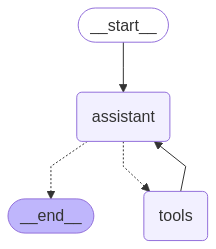

In [4]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, END, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=MemorySaver())

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [5]:
# Input
initial_input = {"messages": HumanMessage(content="Multiply 3 and 3")}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_2q72)
 Call ID: call_2q72
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of the multiplication is 9.


## Browsing History
- Hare we can use `get_state` to look at the current state of our graph, given the `thread_id`

In [6]:
graph.get_state(
    thread
)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2q72', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 'total_tokens': 369, 'completion_time': 0.039410487, 'prompt_time': 0.012153907, 'queue_time': 0.044697631, 'total_time': 0.051564394}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ac132ec1-7cb9-4e1b-a174-9b05fe63d90d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_2q72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 20, 'total_tokens': 369}), ToolMessage(content='9', name='multiply', id='0318adfe-0c93-47d7-9da9-36

In [7]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2q72', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 'total_tokens': 369, 'completion_time': 0.039410487, 'prompt_time': 0.012153907, 'queue_time': 0.044697631, 'total_time': 0.051564394}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ac132ec1-7cb9-4e1b-a174-9b05fe63d90d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_2q72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 20, 'total_tokens': 369}), ToolMessage(content='9', name='multiply', id='0318adfe-0c93-47d7-9da9-36

We can also browse the state history of our agent.

`get_state_history` lets us get the state at all prior steps.


In [8]:
all_states = [s for s in graph.get_state_history(thread)]

In [9]:
len(all_states)

5

In [10]:
all_states[0]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2q72', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 'total_tokens': 369, 'completion_time': 0.039410487, 'prompt_time': 0.012153907, 'queue_time': 0.044697631, 'total_time': 0.051564394}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--ac132ec1-7cb9-4e1b-a174-9b05fe63d90d-0', tool_calls=[{'name': 'multiply', 'args': {'a': 3, 'b': 3}, 'id': 'call_2q72', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 20, 'total_tokens': 369}), ToolMessage(content='9', name='multiply', id='0318adfe-0c93-47d7-9da9-36

In [11]:
all_states[-1]

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c8d1-7112-64cf-bfff-574625789617'}}, metadata={'source': 'input', 'writes': {'__start__': {'messages': HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={})}}, 'step': -1, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-09T04:21:33.749575+00:00', parent_config=None, tasks=(PregelTask(id='f7ce5910-5154-6d53-9706-458a25edcf59', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962')}),), interrupts=())

In [12]:
all_states[-2]

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c8d1-711d-62ad-8000-30472851998b'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-09T04:21:33.754026+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c8d1-7112-64cf-bfff-574625789617'}}, tasks=(PregelTask(id='4717b087-dde2-dc3a-884a-01931dffde6e', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2q72', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 

Everything above we can visualize here: 

![fig1.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038211b544898570be3_time-travel1.png)

## ***Replaying***
- We can re-run our agent from any of the prior steps.

![fig2.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038a0bd34b541c78fb8_time-travel2.png)

In [13]:
to_replay = all_states[-2]
to_replay

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962')]}, next=('assistant',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c8d1-711d-62ad-8000-30472851998b'}}, metadata={'source': 'loop', 'writes': None, 'step': 0, 'parents': {}, 'thread_id': '1'}, created_at='2025-05-09T04:21:33.754026+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02c8d1-7112-64cf-bfff-574625789617'}}, tasks=(PregelTask(id='4717b087-dde2-dc3a-884a-01931dffde6e', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result={'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2q72', 'function': {'arguments': '{"a": 3, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 

In [14]:
to_replay.values

{'messages': [HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962')]}

In [15]:
to_replay.next

('assistant',)

In [16]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c8d1-711d-62ad-8000-30472851998b'}}

To replay from here, we simply pass the config back to the agent!

The graph knows that this checkpoint has aleady been executed. 

It just re-plays from this checkpoint!

In [17]:
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 3 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_dfpy)
 Call ID: call_dfpy
  Args:
    a: 3
    b: 3
================================= Tool Message =================================
Name: multiply

9
================================== Ai Message ==================================

The result of the multiplication is 9.


## **Forking**

What if we want to run from that same step, but with a different input.

This is forking.

![fig3.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbb038f89f2d847ee5c336_time-travel3.png)

In [18]:
to_fork = all_states[-2]
to_fork.values['messages']

[HumanMessage(content='Multiply 3 and 3', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962')]

In [19]:
## and this step config like the checkpoint id is

to_fork.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c8d1-711d-62ad-8000-30472851998b'}}

### Let's modify the state at this checkpoint.

We can just run `update_state` with the `checkpoint_id` supplied. 

Remember how our reducer on `messages` works: 

* It will append, unless we supply a message ID.
* We supply the message ID to overwrite the message, rather than appending to state!

So, to overwrite the the message, we just supply the message ID, which we have `to_fork.values["messages"].id`.

In [20]:
fork_config = graph.update_state(
    to_fork.config,
    {
        "messages": [HumanMessage(content="multiply 5 and 4",
                                  id = to_fork.values['messages'][0].id)]
    },
)

In [21]:
fork_config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f02c906-eb0f-6ef5-8001-ef2d924d37df'}}

### This creates a new, forked checkpoint.
 
But, the metadata - e.g., where to go next - is perserved! 

We can see the current state of our agent has been updated with our fork.

In [22]:
all_states = [state for state in graph.get_state_history(thread)]

In [24]:
all_states[0].values['messages']

[HumanMessage(content='multiply 5 and 4', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962')]

In [25]:
all_states[0].next

('assistant',)

Now, when we stream, the graph knows this checkpoint has never been executed.

So, the graph runs, rather than simply re-playing.

In [27]:
for event in graph.stream(None, fork_config, stream_mode='values'):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

multiply 5 and 4
================================== Ai Message ==================================
Tool Calls:
  multiply (call_zcgj)
 Call ID: call_zcgj
  Args:
    a: 5
    b: 4
================================= Tool Message =================================
Name: multiply

20
================================== Ai Message ==================================

The result of multiplying 5 and 4 is 20.


In [28]:
graph.get_state({'configurable': {'thread_id': '1'}})

StateSnapshot(values={'messages': [HumanMessage(content='multiply 5 and 4', additional_kwargs={}, response_metadata={}, id='1a27610d-44d9-4096-a407-2d776f1f3962'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zcgj', 'function': {'arguments': '{"a": 5, "b": 4}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 349, 'total_tokens': 369, 'completion_time': 0.045961535, 'prompt_time': 0.011018881, 'queue_time': 0.234776734, 'total_time': 0.056980416}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--c239a70f-174c-46df-9184-be49e25655df-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 4}, 'id': 'call_zcgj', 'type': 'tool_call'}], usage_metadata={'input_tokens': 349, 'output_tokens': 20, 'total_tokens': 369}), ToolMessage(content='20', name='multiply', id='d7d64707-a6eb-4b75-8172-f